In [1]:
import time
from pprint import pprint

import cv2
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mmengine.dataset import Compose, pseudo_collate
from mmcv.transforms import BaseTransform
from PIL import Image
import imageio
import json

from mmaction.datasets.transforms.loading import OpenCVInit, OpenCVDecode
from mmaction.datasets.transforms.processing import Resize, CenterCrop
from mmaction.datasets.transforms.formatting import FormatShape, PackActionInputs
from mmaction.apis import inference_recognizer, init_recognizer

# Dataframe

In [2]:
df = pd.read_csv("SLOVO_DATAFRAME.tsv", sep="\t")

In [3]:
df.head(20)

,attachment_id,text,user_id,height,width,length,begin,end
0,44e8d2a0-7e01-450b-90b0-beb7400d2c1e,Ё,185bd3a81d9d618518d10abebf0d17a8,640,360,156.0,36,112
1,df5b08f0-41d1-4572-889c-8b893e71069b,А,185bd3a81d9d618518d10abebf0d17a8,640,360,150.0,36,76
2,17f53df4-c467-4aff-9f48-20687b63d49a,Р,185bd3a81d9d618518d10abebf0d17a8,640,360,133.0,40,97
3,e3add916-c708-4339-ad98-7e2740be29e9,Е,185bd3a81d9d618518d10abebf0d17a8,640,360,144.0,43,107
4,bd7272ed-1850-48f1-a2a8-c8fed523dc37,Ч,185bd3a81d9d618518d10abebf0d17a8,640,360,96.0,20,70
5,eced728b-ec24-4f91-a967-7377542a23e6,Л,185bd3a81d9d618518d10abebf0d17a8,640,360,150.0,31,107
6,cf6845ac-9e02-49b4-8d2b-f56c789f973a,Ц,95af8e702c909eee7145c6dc1a3d756b,640,360,91.0,16,67
7,330fc737-22a8-419b-9e46-b9af6adef8bf,С,185bd3a81d9d618518d10abebf0d17a8,640,360,138.0,32,101
8,a5948d20-283a-45d4-8ab3-9c63f35db522,Й,185bd3a81d9d618518d10abebf0d17a8,640,360,161.0,38,112
9,3f0389e8-fe70-41b0-806d-8c1aae3d20c1,З,185bd3a81d9d618518d10abebf0d17a8,640,360,87.0,8,55


# Stat

In [4]:
print(
    f" Len dataset: {df.__len__()}\n"
    f" Unique users: {df.user_id.unique().__len__()}\n",
    f"Mean video length: {df.length.mean()}\n",
    f"Mean gesture length: {(df.end - df.begin).mean()}"
     )

 Len dataset: 20000
 Unique users: 194
 Mean video length: 106.94655
 Mean gesture length: 49.57225


<Axes: xlabel='user_id', ylabel='Count'>

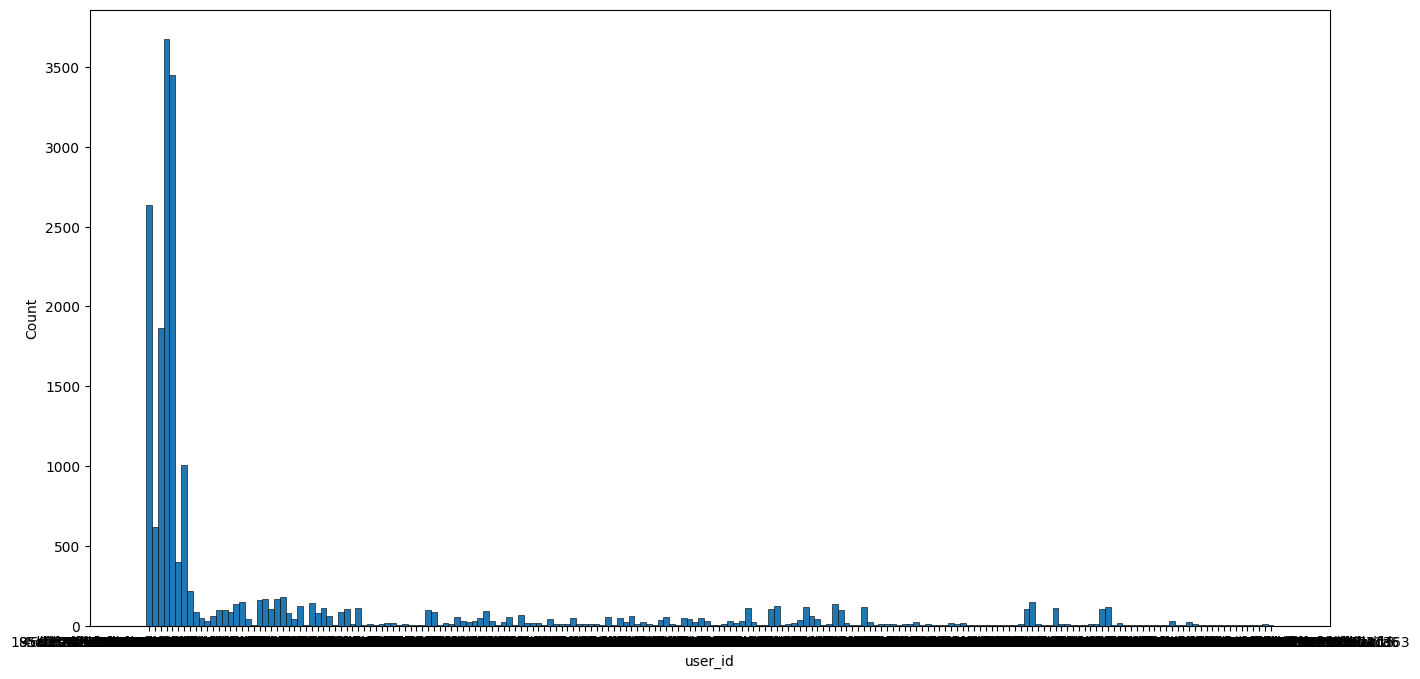

In [5]:
plt.figure(figsize=(16, 8))
sns.histplot(df['user_id'], alpha = 1)

<Axes: xlabel='length', ylabel='Count'>

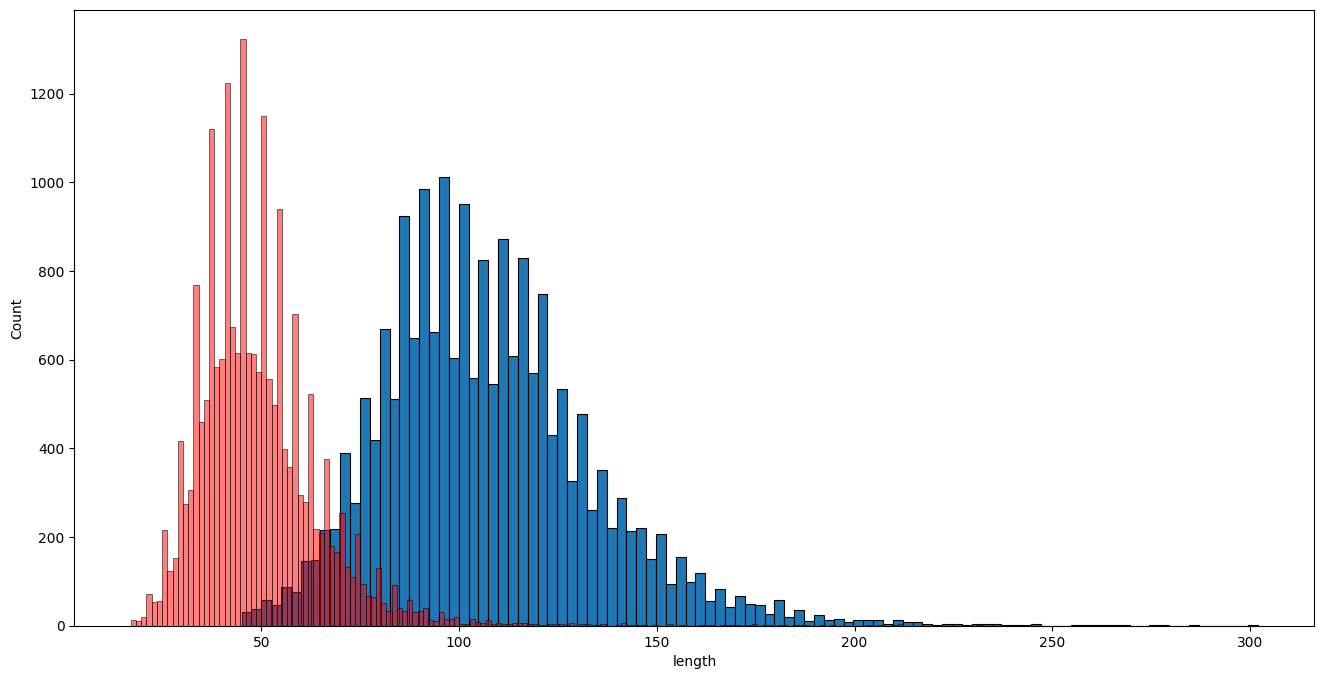

In [6]:
plt.figure(figsize=(16, 8))
sns.histplot(df.length, alpha = 1)
sns.histplot(df['end']-df['begin'], alpha = 0.5, color="red")

<Axes: xlabel='height', ylabel='width'>

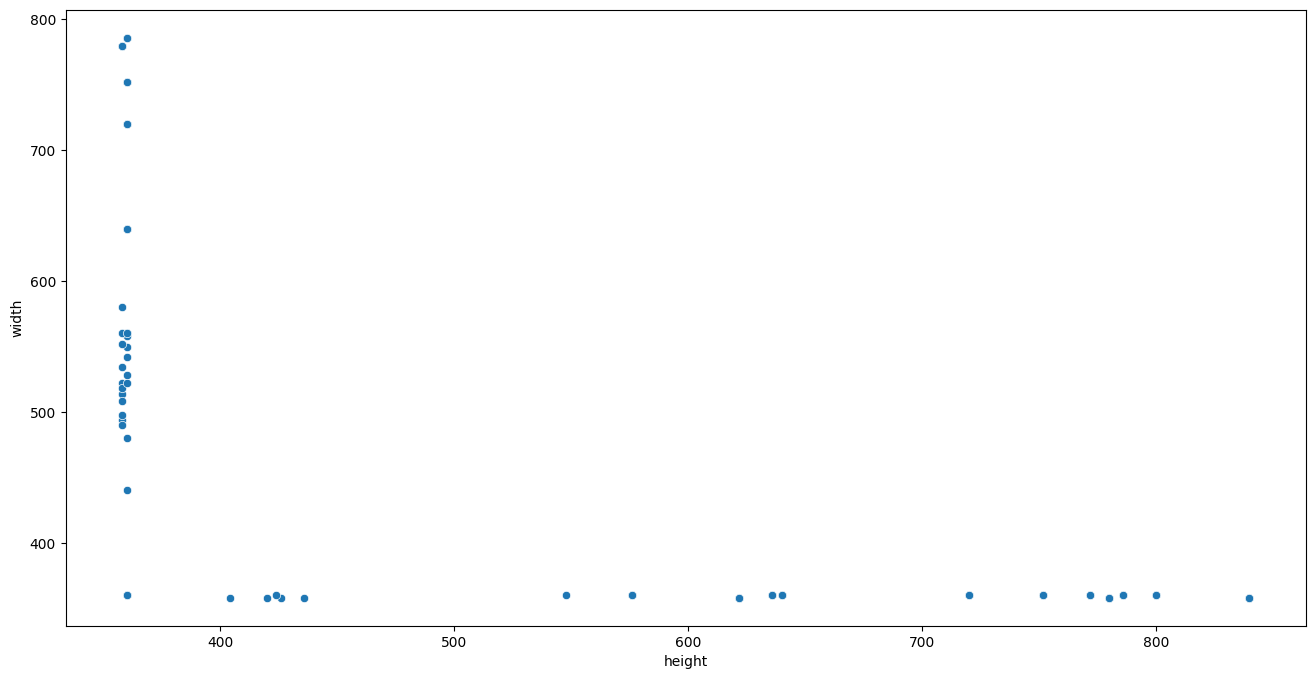

In [7]:
plt.figure(figsize=(16, 8))
sns.scatterplot(df, x='height', y='width')

<Axes: xlabel='length', ylabel='Count'>

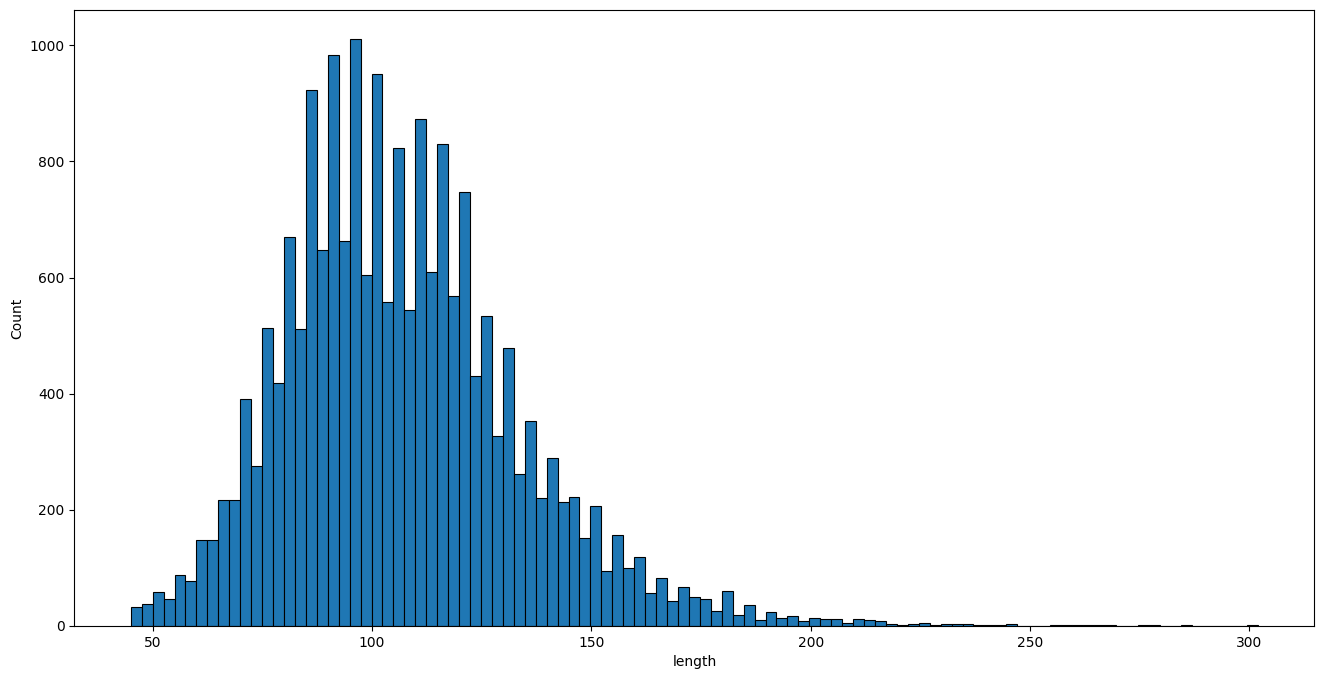

In [8]:
plt.figure(figsize=(16, 8))
sns.histplot(df['length'], alpha = 1)

<Axes: ylabel='Count'>

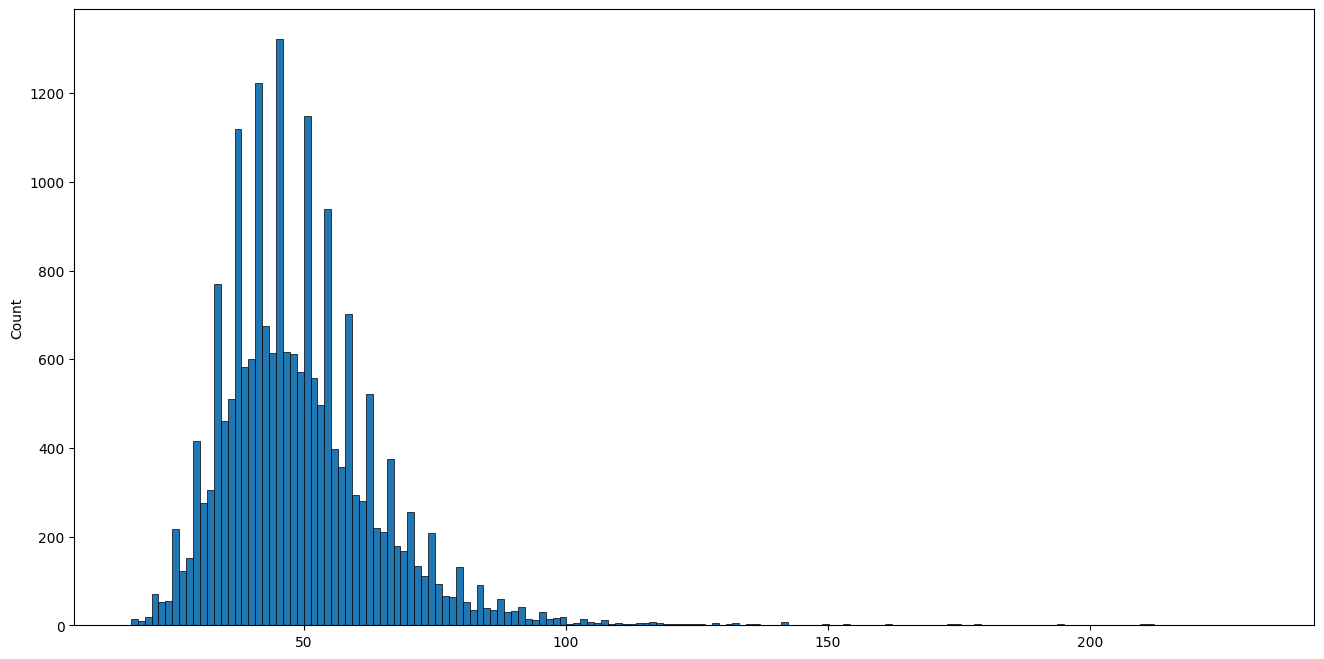

In [9]:
plt.figure(figsize=(16, 8))
sns.histplot(df['end']-df['begin'], alpha = 1)

In [10]:
classes = json.load(open("classes.json"))

In [11]:
df["labels"] = df["text"].apply(lambda x: classes[x])

# Sampling

In [12]:
class SquarePadding(BaseTransform):   
    
    def __init__(self, out_shape):
        self.out_shape = out_shape
        
    def transform(self, results):
        imgs = results['imgs']
        in_shape = results['img_shape']
        out_shape = self.out_shape
        padding = (int((out_shape[1] - in_shape[1]) / 2), int((out_shape[0] - in_shape[0]) / 2))
        pad_func = lambda x: cv2.copyMakeBorder(x, padding[1], padding[1], padding[0], padding[0], cv2.BORDER_CONSTANT, value=(114,114,114))
        
        padded_images = [pad_func(img) for img in imgs]
        results['imgs'] = padded_images
        results['img_shape'] = out_shape
        return results

class SimpleSampler(BaseTransform):
    
    def __init__(self, clip_len=32, frame_interval=1):
        self.clip_len = clip_len
        self.frame_interval = frame_interval
    
    def transform(self, result):
        total_frames = result["total_frames"] - 1
        start_index = result.get("start_index")
        if start_index is None:
            start_index = 0
        end_index = self.clip_len + start_index
        
        result['frame_inds'] = np.arange(start_index, end_index , self.frame_interval)
        
        if end_index > total_frames:
            num_oob = end_index - total_frames
            result['frame_inds'][-num_oob:] = total_frames
        
        result['clip_len'] =  self.clip_len
        result['num_clips'] = 1
        
        return result
        

In [13]:
shape = (300, 300)

simple_sampler = SimpleSampler(
    clip_len=32,
    frame_interval=1
)
opencv_init = OpenCVInit(io_backend='disk')
opencv_decode = OpenCVDecode()
resize = Resize(scale=shape)
square_padding = SquarePadding(out_shape=shape)
center_crop = CenterCrop(crop_size=224)
format_shape = FormatShape(input_format='NCTHW')
pack_input = PackActionInputs()

In [14]:
filename = "0a4b5626-18ec-4e6d-9160-49d7332e476d"
filepath = f"slovo/{filename}.mp4"

In [15]:
result_dict = opencv_init.transform({'filename': filepath})
result_dict['start_index'] = 34
result_dict = simple_sampler(result_dict)
result_dict = opencv_decode(result_dict)

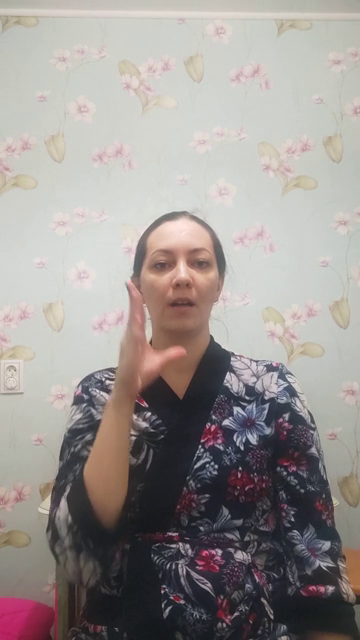

In [16]:
Image.fromarray(result_dict["imgs"][0])

In [17]:
result_dict = resize(result_dict)
result_dict = square_padding(result_dict)
result_dict = center_crop(result_dict)

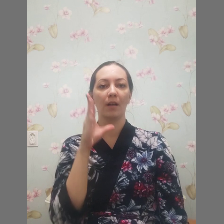

In [18]:
Image.fromarray(result_dict["imgs"][0])

# Baseline

In [19]:
CHECKPOINT = "mvit32.2_small.pth"
CONFIG = "mvit32.2_small_config.py"
DEVICE = "cpu"

In [20]:
model = init_recognizer(CONFIG, CHECKPOINT, device=DEVICE)
_ = model.eval()

Loads checkpoint by local backend from path: mvit32.2_small.pth


In [21]:
pprint(model.cfg.to_dict())

{'model': {'backbone': {'arch': 'small', 'drop_path_rate': 0.2, 'type': 'MViT'},
           'cls_head': {'average_clips': 'prob',
                        'in_channels': 768,
                        'label_smooth_eps': 0.1,
                        'num_classes': 1001,
                        'type': 'MViTHead'},
           'data_preprocessor': {'format_shape': 'NCTHW',
                                 'mean': [123.675, 116.28, 103.53],
                                 'std': [58.395, 57.12, 57.375],
                                 'type': 'ActionDataPreprocessor'},
           'type': 'Recognizer3D'}}


In [22]:
from mmaction.models.backbones.mvit import MViT

In [23]:
pprint(MViT.arch_zoo)

{'base': {'downscale_indices': [2, 5, 21],
          'embed_dims': 96,
          'num_heads': 1,
          'num_layers': 24},
 'large': {'downscale_indices': [2, 8, 44],
           'embed_dims': 144,
           'num_heads': 2,
           'num_layers': 48},
 'small': {'downscale_indices': [1, 3, 14],
           'embed_dims': 96,
           'num_heads': 1,
           'num_layers': 16},
 'tiny': {'downscale_indices': [1, 3, 8],
          'embed_dims': 96,
          'num_heads': 1,
          'num_layers': 10}}


# Heatmap

In [24]:
result_dict = format_shape(result_dict)
result_dict["label"] = -1
result_dict["modality"]='RGB'
result_dict = pack_input(result_dict)
result_dict = pseudo_collate([result_dict])

In [25]:
feature_list = []
model.backbone.blocks[3].pool_skip.register_forward_hook(lambda self, input, output: feature_list.append(input))

In [26]:
with torch.no_grad():
    result = model.test_step(result_dict)[0]

In [27]:
pred_label = result.pred_label.item()
pred_label

629

In [28]:
df[df.attachment_id == filename]

,attachment_id,text,user_id,height,width,length,begin,end,labels
8389,0a4b5626-18ec-4e6d-9160-49d7332e476d,мочь,185bd3a81d9d618518d10abebf0d17a8,640,360,107.0,26,75,629


In [29]:
feature_list[0][0].shape

torch.Size([1, 384, 16, 28, 28])

In [30]:
heatmap = feature_list[0][0][0].numpy()

In [31]:
heatmap[heatmap < 0] = 0
mean_heatmap = heatmap.mean(0)

In [ ]:
hm_frames = []
for hm in mean_heatmap:
    fig, ax = plt.subplots()
    _ = sns.heatmap(hm, ax=ax)
    img_arr = np.frombuffer(fig.canvas.tostring_rgb(), 
                            dtype=np.uint8)
    img_arr  = img_arr.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    hm_frames.append(cv2.resize(img_arr,None,fx=0.5, fy=0.5))

In [33]:
imageio.mimsave("heatmap.mp4", hm_frames, fps=4)

In [34]:
from IPython.display import Video

Video("heatmap.mp4")

In [35]:
from IPython.display import Video

Video(filepath)

# Metric

In [36]:
import numpy as np
from sklearn.metrics import confusion_matrix

def mean_class_accuracy(predicts: list[int], labels: list[int]) -> np.ndarray:
    """Calculate mean class accuracy.

    Args:
        predicts (list[int]): Prediction labels for each class.
        labels (list[int]): Ground truth labels.

    Returns:
        np.ndarray: Mean class accuracy.
    """

    conf_matrix = confusion_matrix(y_pred=predicts, y_true=labels)

    cls_cnt = conf_matrix.sum(axis=1) # all labels
    cls_hit = np.diag(conf_matrix) # true positives

    metrics = [hit / cnt if cnt else 0.0 for cnt, hit in zip(cls_cnt, cls_hit)]
    mean_class_acc = np.mean(metrics)

    return mean_class_acc

In [37]:
pred = np.random.randint(0,1000, 20000)
gt = np.random.randint(0,1000, 20000)
mean_class_accuracy(pred, gt)

0.0010330036322989612

# Speed test 

In [38]:
import time

In [39]:
st = time.time()
out_backbone = model.backbone(torch.randn(1,3,32,224,224))
print(time.time() - st)

9.25413703918457


In [40]:
st = time.time()
_ = model.cls_head(out_backbone)
print(time.time() - st)

0.0016078948974609375


In [ ]:
def model():
    ...

class Model:
    def __call__():
        ...

model = Model()

In [ ]:
videos
32 frames
48 frames
64 frames

In [ ]:
def any_preprocess():
    #before call model
    retun #any tensor

In [ ]:
st = time.time()

out = model()

print(time.time() - st)

# time.time() - st must be < 533